In [9]:
#For-loop version of Monte Carlo simulation to predict MND diagnosis times
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import gamma
from scipy.stats import kstest
import random
import matplotlib.ticker as ticker
import sys

211.9956
107.0


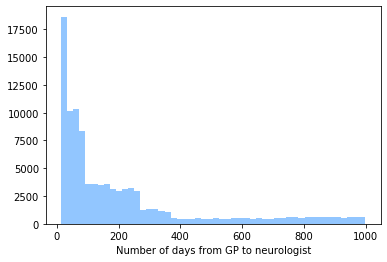

In [10]:
#MND survery: How long from GP to neurologist?
nsim = 100000
a = np.arange(0, nsim, 1)
t = np.zeros_like(a)

for i in a: 
    ran = random.uniform(0, 1)
    if 0 <= ran <= 0.17:
        t[i] = random.uniform(14,30)
    elif 0.17 <= ran <= 0.47:
        t[i] = random.uniform(31,90)
    elif 0.47 <= ran <= 0.63:
        t[i] = random.uniform(91,180)
    elif 0.63 <= ran <= 0.77:
        t[i] = random.uniform(181,270)
    elif 0.77 <= ran <= 0.83:
        t[i] = random.uniform(271,365)
    elif 0.83 <= ran <= 0.92:
        t[i] = random.uniform(366,730)
    elif 0.92 <= ran <= 1:
        t[i] = random.uniform(731,1000)  
        
plt.hist(t, bins = 50)
plt.xlabel('Number of days from GP to neurologist')

print(np.mean(t))
print(np.median(t))

gp2referral_shape = scipy.stats.gamma.fit(t)[0]
gp2referral_loc = scipy.stats.gamma.fit(t)[1]
gp2referral_scale = scipy.stats.gamma.fit(t)[2]
#First and last bins are not uniformly distributed

68.3279
45.36833743471321


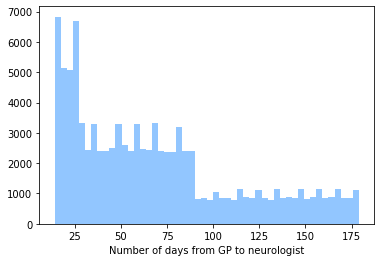

In [28]:
#MND survery: GP2neuro time (0-6 months)
nsim = 100000
a = np.arange(0, nsim, 1)
t = np.zeros_like(a)

for i in a: 
    ran = random.uniform(0, 1)
    if 0 <= ran <= 0.27:
        t[i] = random.uniform(14,30)
    elif 0.27 <= ran <= 0.75:
        t[i] = random.uniform(31,90)
    elif 0.75 <= ran <= 1:
        t[i] = random.uniform(91,180)  
        
plt.hist(t, bins = 50)
plt.xlabel('Number of days from GP to neurologist')

gp2neuro_mean = np.mean(t)
gp2neuro_std = np.std(t)

print(np.mean(t))
print(np.std(t))

gp2neuro_shape = scipy.stats.gamma.fit(t)[0]
gp2neuro_loc = scipy.stats.gamma.fit(t)[1]
gp2neuro_scale = scipy.stats.gamma.fit(t)[2]
#First and last bins are not uniformly distributed

455.92145
254.4493527991327


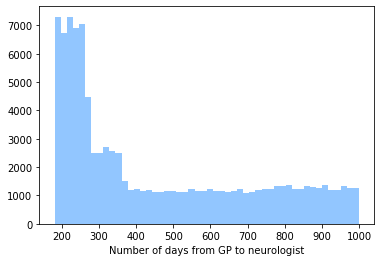

In [29]:
#MND survery: GP2other time (6-24 months)
nsim = 100000
a = np.arange(0, nsim, 1)
t = np.zeros_like(a)

for i in a: 
    ran = random.uniform(0, 1)
    if 0 <= ran <= 0.38:
        t[i] = random.uniform(181,270)
    elif 0.38 <= ran <= 0.53:
        t[i] = random.uniform(271,365)
    elif 0.53 <= ran <= 0.79:
        t[i] = random.uniform(366,730)
    elif 0.79 <= ran <= 1:
        t[i] = random.uniform(731,1000)  
        
plt.hist(t, bins = 50)
plt.xlabel('Number of days from GP to neurologist')

gp2other_mean = np.mean(t)
gp2other_std = np.std(t)

print(np.mean(t))
print(np.std(t))

gp2other_shape = scipy.stats.gamma.fit(t)[0]
gp2other_loc = scipy.stats.gamma.fit(t)[1]
gp2other_scale = scipy.stats.gamma.fit(t)[2]
#First and last bins are not uniformly distributed

257.96857
131.0


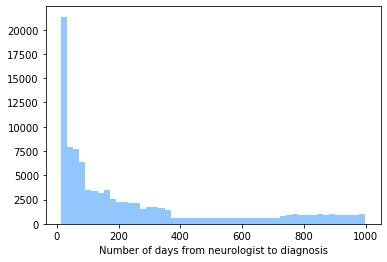

In [30]:
#MND survery: How long from neurologist to diagnosis?
nsim = 100000
a = np.arange(0, nsim, 1)
t = np.zeros_like(a)

for i in a: 
    ran = random.uniform(0, 1)
    if 0 <= ran <= 0.2:
        t[i] = random.uniform(14,30)
    elif 0.2 <= ran <= 0.43:
        t[i] = random.uniform(31,90)
    elif 0.43 <= ran <= 0.58:
        t[i] = random.uniform(91,180)
    elif 0.58 <= ran <= 0.68:
        t[i] = random.uniform(181,270)
    elif 0.68 <= ran <= 0.76:
        t[i] = random.uniform(271,365)
    elif 0.76 <= ran <= 0.87:
        t[i] = random.uniform(366,730)
    elif 0.87 <= ran <= 1:
        t[i] = random.uniform(731,1000)
        
plt.hist(t, bins = 50)
plt.xlabel('Number of days from neurologist to diagnosis')

print(np.mean(t))
print(np.median(t))

neuro2diagnosis_shape = scipy.stats.gamma.fit(t)[0]
neuro2diagnosis_loc = scipy.stats.gamma.fit(t)[1]
neuro2diagnosis_scale = scipy.stats.gamma.fit(t)[2]

In [42]:
#Model variables
 
#Pre-COVID
s2gp = [150,180,14]
delay = [14,14,1]
refdelay = [45,45,14]
gp2neuro = [68,54,14]
gp2other = [458,255,181]
neuro2diagnosis = [259,132,14]
nsim = 100000
p1 = 0.9 
p2 = [0.6,0.3,0.1]
threshold = 365
survival = [879,690, 1733]

covid_factor = 1.5

#COVID probabilities at peak, no change in time
covid1_prob_p1 = 0.66 
covid1_prob_p2 = [0.3,0.15,0.55]

#COVID primary care increase 50%
covid_s2gp = [i * covid_factor for i in s2gp]
covid_delay = [i * covid_factor for i in delay]

#COVID secondary care increase 50%
covid_refdelay = [i * covid_factor for i in refdelay]
covid_gp2neuro = [i * covid_factor for i in gp2neuro]
covid_gp2other = [i * covid_factor for i in gp2other]
covid_neuro2diagnosis = [i * covid_factor for i in neuro2diagnosis]

In [43]:
def pathway_simulation1(s2gp, delay, refdelay, gp2neuro, gp2other, neuro2diagnosis, nsim, p1, p2, threshold, survival):
    '''
    #Setting up the distributions for each step. We can change the distribution type, mean and SD. The references
    #will dictate what the distributions, mean, SD etc are. 

# UNITS ARE IN DAYS

    Args:
        s2gp (1x3 array): mean, SD and min time taken from symptom onset to presentation to first medical contact
        delay (1x3 array): mean, SD and min time delay in presentation
        refdelay (1x3 array): mean, SD and min time delay after referral to other
        gp2neuro (1x3 array): mean, SD and min time taken from gp to neurology appointment
        gp2other (1x3 array): mean, SD and min time taken from gp to other, non-neuro (ortho, ENT etc) appointment
        neuro2diagnosis (1x3 array): mean, SD and min time taken from neurology appointment to diagnosis
        p1 (scalar value): value between 0 and 1 - the probability that patient goes to GP when they have symptoms
        p2 (1x3 array): value between 0 and 1 - the probability that patient is correctly referred to neurologist,
        non-neurologist or not referred at all (should sum to 1)
        nsim (scalar): number of simulation in Monte Carlo simulation
        threshold (scalar): proportion of people are seen in 'threshold' amount of time
        survival (1x2 array): median number of days from symptom onset to death for ALS and bulbar

    '''    
    
    # Set up probability distribution
    #Loc actually sets the minimum of the distribution
    #Shape (alpha) = (mean/SD)**2
    #Scale (beta) = (SD**2)/mean
    symptom_to_gp = gamma(a = (s2gp[0]/s2gp[1])**2, loc = s2gp[2], scale = (s2gp[1]**2)/s2gp[0])
    gp_delay_period = gamma(a = (delay[0]/delay[1])**2, loc = delay[2], scale = (delay[1]**2)/delay[0])
    referral_delay_period = gamma(a = (refdelay[0]/refdelay[1])**2, loc = refdelay[2], scale = (refdelay[1]**2)/refdelay[0]) 
    
    if not gp2neuro:
        gp_to_neuro = gamma(a = gp2neuro_shape, loc = gp2neuro_loc, scale = gp2neuro_scale)
    else:
        gp_to_neuro = gamma(a = (gp2neuro[0]/gp2neuro[1])**2, loc = gp2neuro[2], scale = (gp2neuro[1]**2)/gp2neuro[0])
    
    if not gp2other:
        gp_to_other = gamma(a = gp2other_shape, loc = gp2other_loc, scale = gp2other_scale)
    else:
        gp_to_other = gamma(a = (gp2other[0]/gp2other[1])**2, loc = gp2other[2], scale = (gp2other[1]**2)/gp2other[0])
    
    if not neuro2diagnosis:
        neuro_to_diagnosis = gamma(a = neuro2diagnosis_shape, loc = neuro2diagnosis_loc, scale = neuro2diagnosis_scale)
    else:
        neuro_to_diagnosis = gamma(a = (neuro2diagnosis[0]/neuro2diagnosis[1])**2, loc = neuro2diagnosis[2], scale = (neuro2diagnosis[1]**2)/neuro2diagnosis[0])
    
    #Number of simulations
    number_of_simulations = nsim
    
    t = np.arange(0, nsim, 1)
    s2gp_times = np.zeros_like(t)
    delay_times = np.zeros_like(t)
    refdelay_times = np.zeros_like(t)
    gp2neuro_times = np.zeros_like(t)
    gp2other_times = np.zeros_like(t)
    neuro2diagnosis_times = np.zeros_like(t)
    total_time = np.zeros_like(t)

    #Simulate the pathway
    for i in t:
    #Generate random number between 0 and 1. Use this number to dictate if patient goes from GP to neuro or other.
        r1 = random.uniform(0, 1)
        r2 = random.uniform(0, 1)
        return_to_gp = 0
    
    #Symptom onset to GP appointment
        if r1 <= p1: #p1 of people with MND will do straight to the GP
            symptom_to_gp_times = symptom_to_gp.rvs()
            gp_delay_times = 0
        else: 
            symptom_to_gp_times = symptom_to_gp.rvs()
            gp_delay_times = gp_delay_period.rvs()
            
    #GP to referral
        while return_to_gp < 1:
            if r2 <= p2[0]: #people are referred to neurologist
                gp_to_neuro_times = gp_to_neuro.rvs() #sample from gp2neuro
                gp_to_other_times = 0
                referral_delay_times = 0
                return_to_gp = 1
            elif p2[0] <= r2 <= p2[0]+p2[1]: #people referred to non-neurologist first
                gp_to_other_times = gp_to_other.rvs() #first see a non-neurologist 
                referral_delay_times = referral_delay_period.rvs() #then have a delay before going back to the GP
                gp_to_neuro_times = gp_to_neuro.rvs() #then correctly get referred to a neurologist
                return_to_gp = 1
            elif r2 > p2[0]+p2[1]: #people not referred at all
                gp_delay_times = gp_delay_times + gp_delay_period.rvs() #see GP again with delay
                referral_delay_times = 0
                r2 = random.uniform(0, 1) #pick a new random number for r2
                return_to_gp = 0 #loops back and patient re-enters GP practice

    #Neurology appointment to diagnosis              
        neuro_to_diagnosis_times = neuro_to_diagnosis.rvs()

    #Overall equation for calculating the total time to diagnosis
        s2gp_times[i] = symptom_to_gp_times
        delay_times[i] = gp_delay_times
        refdelay_times[i] = referral_delay_times
        gp2neuro_times[i] = gp_to_neuro_times
        gp2other_times[i] = gp_to_other_times
        neuro2diagnosis_times[i] = neuro_to_diagnosis_times
        total_time[i] = symptom_to_gp_times + gp_delay_times + referral_delay_times + gp_to_neuro_times + gp_to_other_times + neuro_to_diagnosis_times
        
    #Plotting the overall distribution of times taken to go through the clinical pathway
    nbins = 50
    
    fig = plt.figure(figsize=(20,10))
    plt.style.use('seaborn-pastel')
    grid = plt.GridSpec(2, 3, hspace=0.2, wspace=0.2)
    ax1 = fig.add_subplot(grid[0:2, 0])
    ax2 = fig.add_subplot(grid[0, 1])
    ax3 = fig.add_subplot(grid[0, 2])
    ax4 = fig.add_subplot(grid[1, 1])
    ax5 = fig.add_subplot(grid[1, 2]);

    #Set up axes
    ax1.hist(total_time, nbins)
    ax1.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(total_time)))
    ax1.set_xlim([0, np.max(total_time)])
    ax2.hist(s2gp_times, nbins)
    ax2.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(s2gp_times)))
    ax2.set_xlim([0, np.max(s2gp_times)])
    ax3.hist(gp2neuro_times, nbins)
    ax3.set_xlim([0, np.max(gp2neuro_times)])
    ax3.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(gp2neuro_times)))
    ax4.hist(gp2other_times[gp2other_times != 0], nbins)
    ax4.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(gp2other_times)))
    ax4.set_xlim([0, np.max(gp2other_times)])
    ax5.hist(neuro2diagnosis_times, nbins)
    ax5.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(neuro2diagnosis_times)))
    ax5.set_xlim([0, np.max(neuro2diagnosis_times)])
    
    ax1.set_xlabel('Days')
    ax1.set_ylabel('Percentage of people')
    ax1.set_title('Total time from symptom onset to diagnosis')
    ax2.set_title('Symptom onset to GP')
    ax3.set_title('GP to Neurology referral')
    ax4.set_title('GP to non-neurology referral')
    ax5.set_title('Neurology appointment to diagnosis')

    #Print valuable information
    print("Proportion of people diagnosed before threshold =",np.mean(total_time < threshold))
    print("Proportion of ALS presenting as emergencies =",np.mean(total_time > survival[0]))
    print("Proportion of bulbar presenting as emergencies =",np.mean(total_time > survival[1]))
    print("Proportion of limb presenting as emergencies =",np.mean(total_time > survival[2]))
    print("Mean time =",np.mean(total_time))
    print("Median time =",np.median(total_time))
    print("Min time =",np.min(total_time))
    
    return total_time

#Cumulative time at each step for each phenotype. If within 30 days of median death for each phenotype 
#then patient counts as having an emergency presentation. Have a counter that counts these emergency presentations.
#We expect that the delays due to COVID will results in more emergency presentations. 

Proportion of people diagnosed before threshold = 0.38005
Proportion of ALS presenting as emergencies = 0.17664
Proportion of bulbar presenting as emergencies = 0.29549
Proportion of limb presenting as emergencies = 0.01162
Mean time = 556.93198
Median time = 470.0
Min time = 42


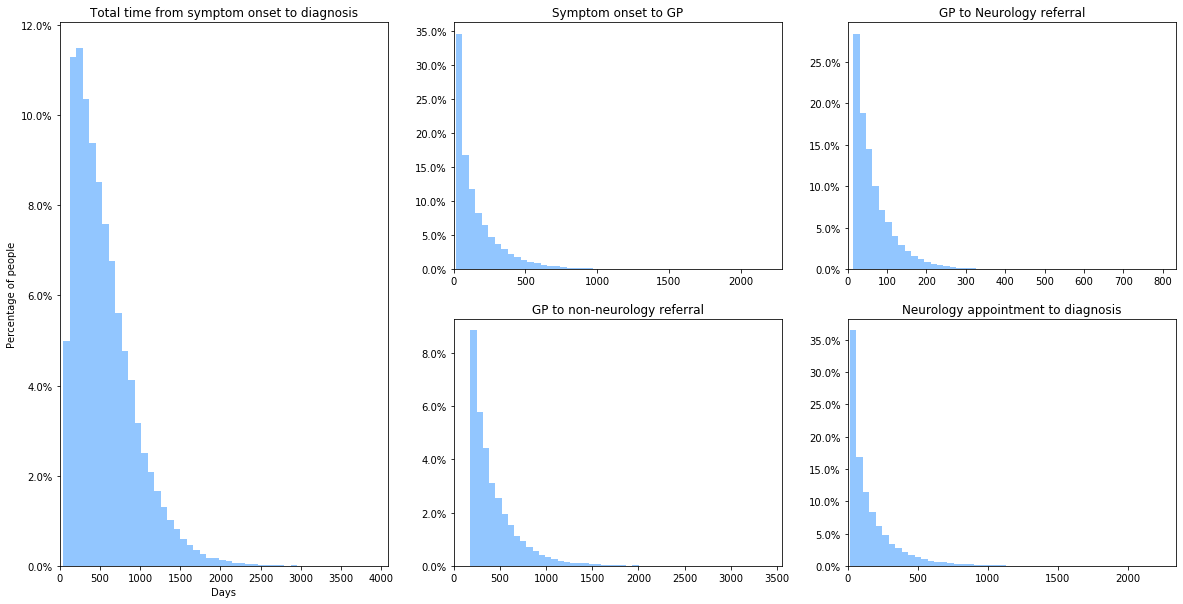

In [44]:
#Pre-COVID model
preCOVID = pathway_simulation1(s2gp, delay, refdelay, [] , [] , [], nsim = 100000, p1 = p1, p2 = p2, threshold = 365, survival = survival)

Proportion of people diagnosed before threshold = 0.35205
Proportion of ALS presenting as emergencies = 0.1879
Proportion of bulbar presenting as emergencies = 0.31273
Mean time = 577.48437
Median time = 493.0
Min time = 46


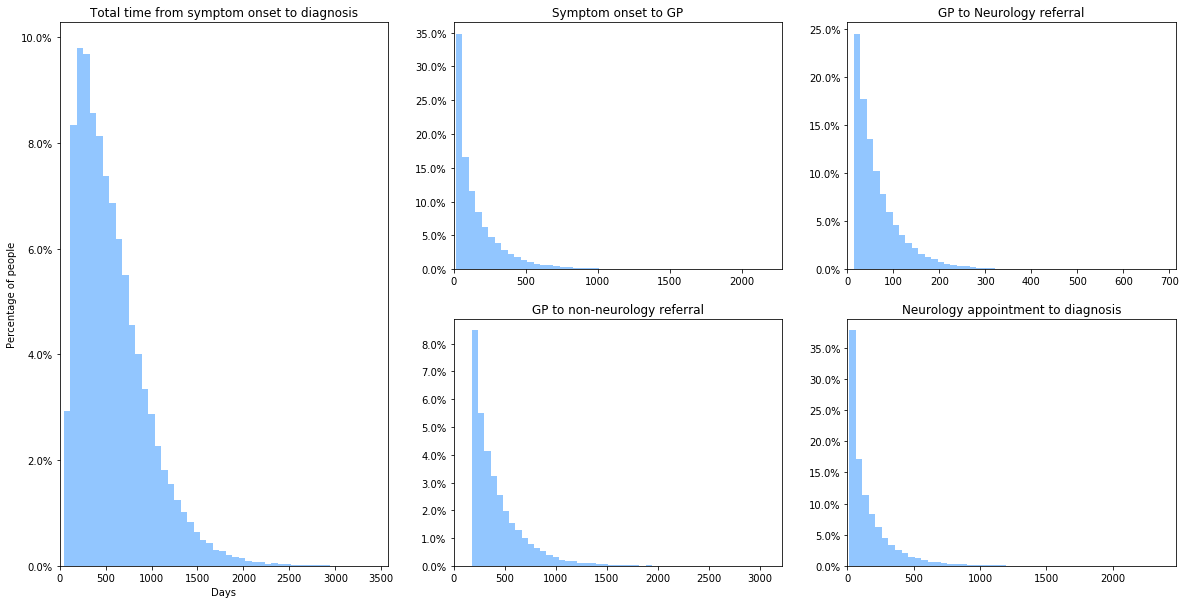

In [38]:
#COVID probabilities only
COVID = pathway_simulation1(s2gp, delay, refdelay, [], [], [], nsim = 100000, p1 = covid1_prob_p1, p2 = covid1_prob_p2, threshold = 365, survival = survival)

Proportion of people diagnosed before threshold = 0.1009
Proportion of ALS presenting as emergencies = 0.41192
Proportion of bulbar presenting as emergencies = 0.551
Proportion of limb presenting as emergencies = 0.05638
Mean time = 870.52317
Median time = 755.0
Min time = 90


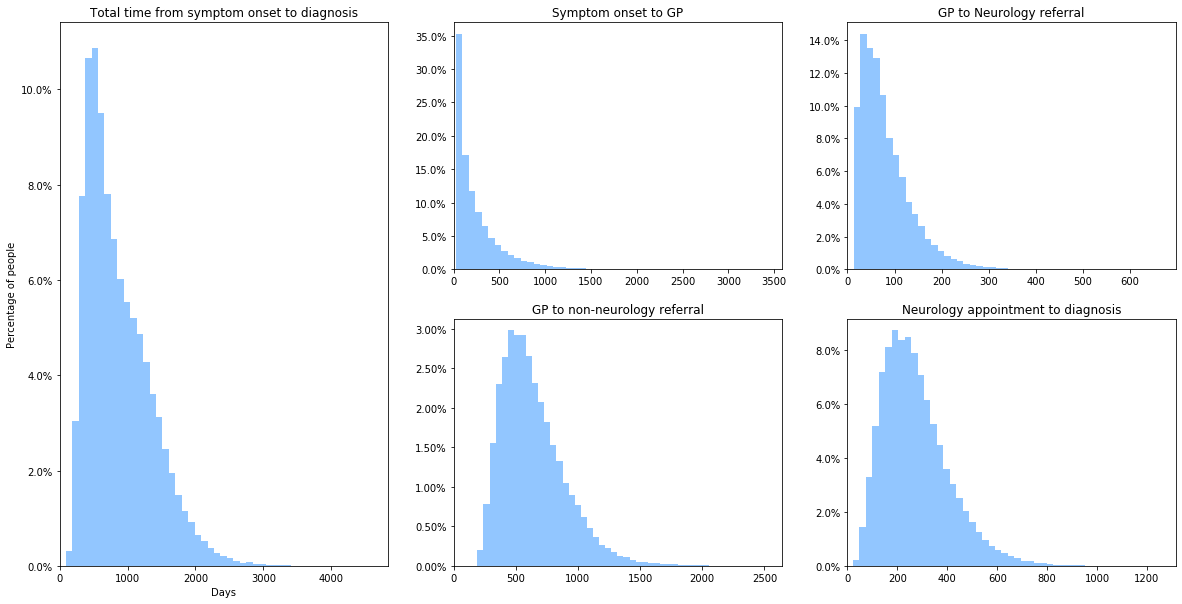

In [45]:
#COVID model - primary care only
COVID = pathway_simulation1(covid_s2gp, covid_delay, refdelay, gp2neuro, gp2other, neuro2diagnosis, nsim = 100000, p1 = covid1_prob_p1, p2 = covid1_prob_p2, threshold = 365, survival = survival)

Proportion of people diagnosed before threshold = 0.04323
Proportion of ALS presenting as emergencies = 0.49301
Proportion of bulbar presenting as emergencies = 0.65119
Mean time = 1069.08568
Median time = 870.0
Min time = 130


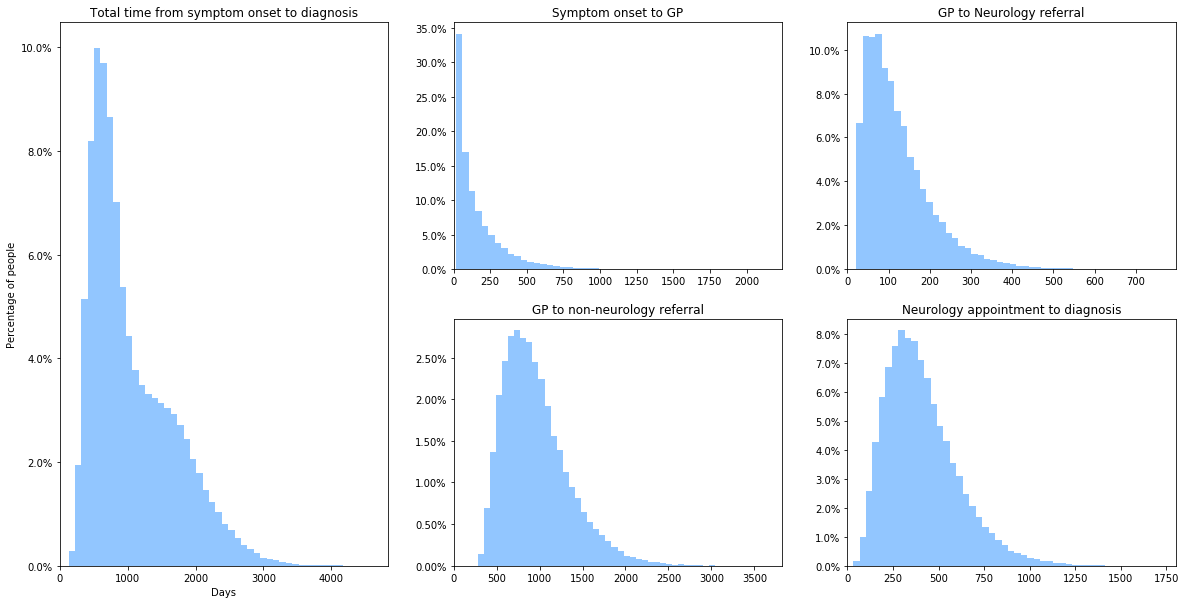

In [40]:
#COVID model - secondary care only
COVID = pathway_simulation1(s2gp, delay, covid_refdelay, covid_gp2neuro, covid_gp2other, covid_neuro2diagnosis, nsim = 100000, p1 = covid1_prob_p1, p2 = covid1_prob_p2, threshold = 365, survival = survival)

Proportion of people diagnosed before threshold = 0.02743
Proportion of ALS presenting as emergencies = 0.56296
Proportion of bulbar presenting as emergencies = 0.72029
Proportion of limb presenting as emergencies = 0.19578
Mean time = 1162.7981
Median time = 975.0
Min time = 128


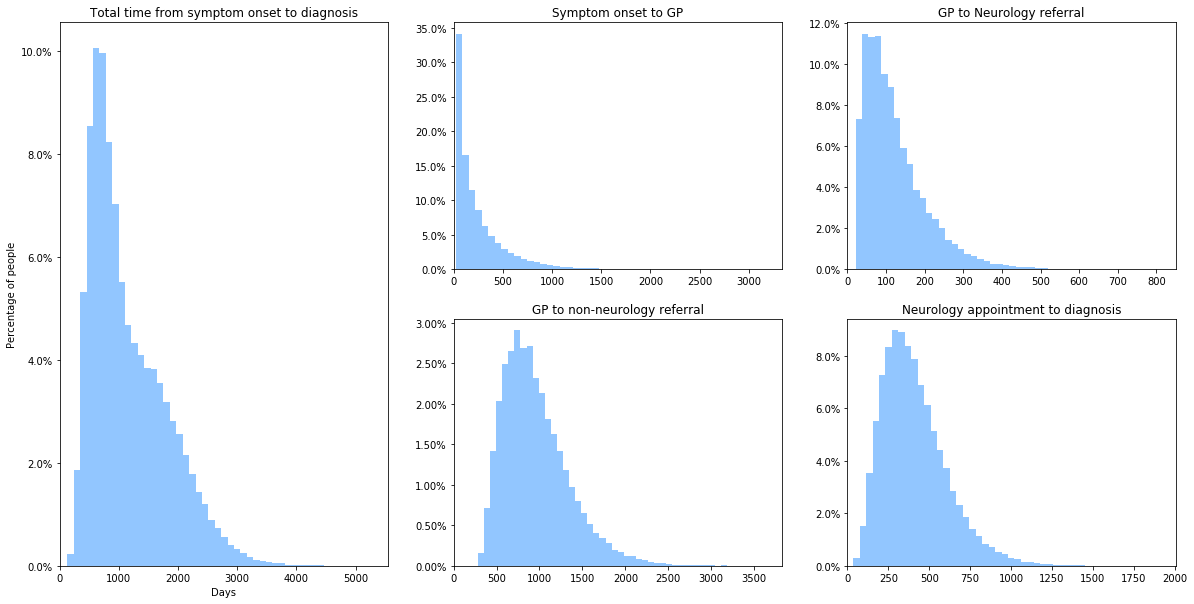

In [46]:
#COVID model - all proccesses lengthened
COVID = pathway_simulation1(covid_s2gp, covid_delay, covid_refdelay, covid_gp2neuro, covid_gp2other, covid_neuro2diagnosis, nsim = 100000, p1 = covid1_prob_p1, p2 = covid1_prob_p2, threshold = 365, survival = survival)

In [ ]:
#Changing first paramter in gamma function: 1=exponential function. Increasing this makes the distribution more normal.
#Loc actually sets the minimum of the distribution
#Shape (alpha) = (mean/SD)**2
#Scale (beta) = (SD**2)/mean
s2gp = [150,180]
shape = (s2gp[0]/s2gp[1])**2 
Scale = (s2gp[1]**2)/s2gp[0]

symptom_to_gp = gamma(a = shape, loc = 14, scale = Scale)
symptom_to_gp_times = symptom_to_gp.rvs(100000)
print("Min time =",(np.min(symptom_to_gp_times)))
print("Median time =",(np.median(symptom_to_gp_times)))
print("Mean time =",(np.mean(symptom_to_gp_times)))
print(np.max(symptom_to_gp_times))

plt.hist(symptom_to_gp_times, bins = 50)
plt.xlim(0,800)
plt.xlabel('Number of days from symptom onset to diagnosis')
plt.show()

print(np.mean(symptom_to_gp_times < 30))
print(np.mean(symptom_to_gp_times < 90))
print(np.mean(symptom_to_gp_times < 180))
print(np.mean(symptom_to_gp_times < 270))
print(np.mean(symptom_to_gp_times < 365))
print(np.mean(symptom_to_gp_times < 730))
print(np.mean(symptom_to_gp_times < 900))

In [ ]:
#SECOND MODEL - no GP2other, uses GP2referral
def pathway_simulation2(s2gp, delay, gp2neuro, neuro2diagnosis, nsim, p1, p2, threshold, survival):
    '''
    #Setting up the distributions for each step. We can change the distribution type, mean and SD. The references
    #will dictate what the distributions, mean, SD etc are. 

# UNITS ARE IN DAYS

    Args:
        s2gp (1x3 array): mean, SD and min time taken from symptom onset to presentation to first medical contact
        delay (1x3 array): mean, SD and min time delay in presentation
        gp2neuro (1x3 array): mean, SD and min time taken from gp to neurology appointment, including referrals
        to other specialties
        neuro2diagnosis (1x3 array): mean, SD and min time taken from neurology appointment to diagnosis
        p1 (scalar value): value between 0 and 1 - the probability that patient goes to GP when they have symptoms
        p2 (scalar value): value between 0 and 1 - the probability that patient referred
        nsim (scalar): number of simulation in Monte Carlo simulation
        threshold (scalar): proportion of people are seen in 'threshold' amount of time
        survival (scalar): median number of days from symptom onset to death

    '''    

    #Number of simulations
    number_of_simulations = nsim
    
    # Set up probability distribution
    #Loc sets the minimum of the distribution
    #Shape (alpha) = (mean/SD)**2
    #Scale (beta) = (SD**2)/mean
    symptom_to_gp = gamma(a = (s2gp[0]/s2gp[1])**2, loc = s2gp[2], scale = (s2gp[1]**2)/s2gp[0])
    gp_delay_period = gamma(a = (delay[0]/delay[1])**2, loc = delay[2], scale = (delay[1]**2)/delay[0])
    
    if not gp2neuro:
        gp_to_neuro = gamma(a = gp2referral_shape, loc = gp2referral_loc, scale = gp2referral_scale)
    else:
        gp_to_neuro = gamma(a = (gp2neuro[0]/gp2neuro[1])**2, loc = gp2neuro[2], scale = (gp2neuro[1]**2)/gp2neuro[0])
    
    if not neuro2diagnosis:
        neuro_to_diagnosis = gamma(a = neuro2diagnosis_shape, loc = neuro2diagnosis_loc, scale = neuro2diagnosis_scale)
    else:
        neuro_to_diagnosis = gamma(a = (neuro2diagnosis[0]/neuro2diagnosis[1])**2, loc = neuro2diagnosis[2], scale = (neuro2diagnosis[1]**2)/neuro2diagnosis[0])
    
    
    t = np.arange(0, nsim, 1)
    s2gp_times = np.zeros_like(t)
    delay_times = np.zeros_like(t)
    gp2neuro_times = np.zeros_like(t)
    neuro2diagnosis_times = np.zeros_like(t)
    total_time = np.zeros_like(t)

    #Simulate the pathway
    for i in t:
    #Generate random number between 0 and 1. Use this number to dictate if patient goes from GP to neuro or other.
        r1 = random.uniform(0, 1)
        r2 = random.uniform(0, 1)
        return_to_gp = 0
    
    #Symptom onset to GP appointment
        if r1 <= p1: #p1 of people with MND will do straight to the GP
            symptom_to_gp_times = symptom_to_gp.rvs()
            gp_delay_times = 0
        else: 
            symptom_to_gp_times = symptom_to_gp.rvs()
            gp_delay_times = gp_delay_period.rvs()
            
    #GP to referral
        while return_to_gp < 1:
            if r2 <= p2: #people are referred
                gp_to_neuro_times = gp_to_neuro.rvs() #sample from gp2neuro
                return_to_gp = 1
            else: #people not referred at all
                gp_delay_times = gp_delay_times + gp_delay_period.rvs() #see GP again with delay
                r2 = random.uniform(0, 1) #pick a new random number for r2
                return_to_gp = 0 #loops back and patient re-enters GP practice
            #SEPARATE DELAY TIMES
    #Neurology appointment to diagnosis              
        neuro_to_diagnosis_times = neuro_to_diagnosis.rvs()

    #Overall equation for calculating the total time to diagnosis
        s2gp_times[i] = symptom_to_gp_times
        delay_times[i] = gp_delay_times
        gp2neuro_times[i] = gp_to_neuro_times
        neuro2diagnosis_times[i] = neuro_to_diagnosis_times
        total_time[i] = symptom_to_gp_times + gp_delay_times + gp_to_neuro_times + neuro_to_diagnosis_times
        
    #Plotting the overall distribution of times taken to go through the clinical pathway
    nbins = 50
    
    fig = plt.figure(figsize=(20,10))
    plt.style.use('seaborn-pastel')
    grid = plt.GridSpec(2, 2, hspace=0.2, wspace=0.2)
    ax1 = fig.add_subplot(grid[0, 0])
    ax2 = fig.add_subplot(grid[0, 1])
    ax3 = fig.add_subplot(grid[1, 0])
    ax4 = fig.add_subplot(grid[1, 1]);

    #Set up axes
    ax1.hist(total_time, nbins)
    ax1.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(total_time)))
    ax1.set_xlim([0, np.max(total_time)])
    
    ax2.hist(s2gp_times, nbins)
    ax2.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(s2gp_times)))
    ax2.set_xlim([0, np.max(s2gp_times)])
    
    ax3.hist(gp2neuro_times, nbins)
    ax3.set_xlim([0, np.max(gp2neuro_times)])
    ax3.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(gp2neuro_times)))
    
    ax4.hist(neuro2diagnosis_times, nbins)
    ax4.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=len(neuro2diagnosis_times)))
    ax4.set_xlim([0, np.max(neuro2diagnosis_times)])
    
    ax1.set_xlabel('Days')
    ax1.set_ylabel('Percentage of people')
    ax1.set_title('Total time from symptom onset to diagnosis')
    ax2.set_title('Symptom onset to GP')
    ax3.set_title('GP to Neurology referral')
    ax4.set_title('Neurology appointment to diagnosis')

    #Print valuable information
    print("Proportion of people diagnosed before threshold =",np.mean(total_time < threshold))
    print("Proportion of people presenting as emergencies =",np.mean(total_time > survival))
    print("Mean time =",np.mean(total_time))
    print("Median time =",np.median(total_time))
    print("Min time =",np.min(total_time))
    
    return total_time

#Cumulative time at each step for each phenotype. If within 30 days of median death for each phenotype 
#then patient counts as having an emergency presentation. Have a counter that counts these emergency presentations.
#We expect that the delays due to COVID will results in more emergency presentations. 

#6 weeks for non-neurology, 2nd GP waiting time
#GP2neuro from MND survey may include time taken to see other rando, too; gp2neuro = gp2rando+rando2neuro
#If referred to other, draw sample from >6m gp2neuro, if neuro draw sample from <6m